## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

download = True
valid_size = 0.2
num_workers = 10
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

# Obtain training indices that will be used for validation
num_train = len(fmnist_dataset_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           sampler=train_sampler,
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])
128


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128])

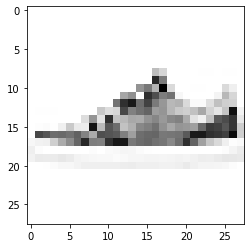

In [7]:
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(img[0].permute(1, 2, 0)), cmap='Greys')

next(iter(train_loader))[1].size()

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [31]:
import torch.nn.functional as F

class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [32]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 512]         262,656
       BatchNorm1d-7                  [-1, 512]           1,024
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
       LogSoftmax-11                   [-1, 10]               0
Total params: 671,754
Trainable params: 671,754
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Your experiments come here:

In [33]:
%%time
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(),lr = 0.01)
loss_func = nn.NLLLoss()

n_epochs = 50
valid_loss_min = np.Inf  

for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data,label in train_loader:
        opt.zero_grad()
        
        # Forward
        output = model(data.to(device))
        loss = loss_func(output,label.to(device))
        
        # Backward
        loss.backward()
        opt.step()
        
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data,label in valid_loader:
        # Forward
        output = model(data.to(device))
        loss = loss_func(output,label.to(device))
        
        valid_loss = loss.item() * data.size(0)
    
    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Loss: 0.729784 	Validation Loss: 0.003308
Validation loss decreased (inf --> 0.003308).  Saving model ...
Epoch: 2 	Training Loss: 0.474706 	Validation Loss: 0.003205
Validation loss decreased (0.003308 --> 0.003205).  Saving model ...
Epoch: 3 	Training Loss: 0.421036 	Validation Loss: 0.002172
Validation loss decreased (0.003205 --> 0.002172).  Saving model ...
Epoch: 4 	Training Loss: 0.391765 	Validation Loss: 0.002532
Epoch: 5 	Training Loss: 0.371240 	Validation Loss: 0.003081
Epoch: 6 	Training Loss: 0.356071 	Validation Loss: 0.003178
Epoch: 7 	Training Loss: 0.341203 	Validation Loss: 0.004407
Epoch: 8 	Training Loss: 0.329372 	Validation Loss: 0.002953
Epoch: 9 	Training Loss: 0.318351 	Validation Loss: 0.003635
Epoch: 10 	Training Loss: 0.310302 	Validation Loss: 0.002327
Epoch: 11 	Training Loss: 0.299797 	Validation Loss: 0.002222
Epoch: 12 	Training Loss: 0.291960 	Validation Loss: 0.002432
Epoch: 13 	Training Loss: 0.283092 	Validation Loss: 0.003100
E

In [34]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [35]:
##################    
# test the model #
##################

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # Forward
    output = model.forward(data.to(device))
    loss = loss_func(output, target.to(device))
    
    test_loss += loss.item()*data.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    
    # Calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test Loss: 0.333313

Test Accuracy of     0: 82% (821/1000)
Test Accuracy of     1: 97% (974/1000)
Test Accuracy of     2: 71% (719/1000)
Test Accuracy of     3: 92% (923/1000)
Test Accuracy of     4: 88% (882/1000)
Test Accuracy of     5: 96% (963/1000)
Test Accuracy of     6: 71% (718/1000)
Test Accuracy of     7: 96% (966/1000)
Test Accuracy of     8: 97% (973/1000)
Test Accuracy of     9: 95% (955/1000)

Test Accuracy (Overall): 88% (8894/10000)


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [29]:
# Let's decrease the size of train 4 times

overfitted_train_index = train_index[:int(len(train_index)/8)]
overfitted_train_sampler = SubsetRandomSampler(train_index)
overfitted_train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           sampler=overfitted_train_sampler,
                                           num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [31]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              Tanh-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
              Tanh-5                 [-1, 1024]               0
            Linear-6                 [-1, 1024]       1,049,600
              Tanh-7                 [-1, 1024]               0
            Linear-8                 [-1, 1024]       1,049,600
              Tanh-9                 [-1, 1024]               0
           Linear-10                 [-1, 1024]       1,049,600
             Tanh-11                 [-1, 1024]               0
           Linear-12                 [-1, 1024]       1,049,600
             Tanh-13                 [-1, 1024]               0
           Linear-14                 [-

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [35]:
%%time
overfitted_model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(overfitted_model.parameters(),lr = 0.001)
loss_func = nn.NLLLoss()

n_epochs = 50
valid_loss_min = np.Inf  

train_losses = []
valid_losses = []

val_accs = []

for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    # To compute then validation accuracy
    val_class_correct = list(0. for i in range(10))
    val_class_total = list(0. for i in range(10))

    ###################
    # train the model #
    ###################
    overfitted_model.train()
    for data,label in overfitted_train_loader:
        opt.zero_grad()
        
        # Forward
        output = overfitted_model(data.to(device))
        loss = loss_func(output,label.to(device))
        
        # Backward
        loss.backward()
        opt.step()
        
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    overfitted_model.eval()
    for data,label in valid_loader:
        # Forward
        output = overfitted_model(data.to(device))
        loss = loss_func(output,label.to(device))
        
        valid_loss = loss.item() * data.size(0)
        
        # Convert output probabilities to predicted class
        pred = torch.argmax(output, dim=1)
        # Compare predictions to true label
        correct = np.squeeze(pred.eq(label.to(device).data.view_as(pred)))
    
        # Calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    val_avrg_acc = 100. * np.sum(class_correct) / np.sum(class_total)
    val_accs.append(val_avrg_acc)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation average accuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss, 
        val_avrg_acc
        ))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(overfitted_model.state_dict(), 'overfitted_model.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Loss: 2.302895 	Validation Loss: 0.018395 	Validation average accuracy: 48.070236
Validation loss decreased (inf --> 0.018395).  Saving model ...
Epoch: 2 	Training Loss: 2.302668 	Validation Loss: 0.018420 	Validation average accuracy: 43.719250
Epoch: 3 	Training Loss: 2.302448 	Validation Loss: 0.018447 	Validation average accuracy: 40.249449
Epoch: 4 	Training Loss: 2.302233 	Validation Loss: 0.018417 	Validation average accuracy: 37.375125
Epoch: 5 	Training Loss: 2.302019 	Validation Loss: 0.018427 	Validation average accuracy: 35.022831
Epoch: 6 	Training Loss: 2.301808 	Validation Loss: 0.018429 	Validation average accuracy: 33.158116
Epoch: 7 	Training Loss: 2.301595 	Validation Loss: 0.018416 	Validation average accuracy: 31.542284
Epoch: 8 	Training Loss: 2.301379 	Validation Loss: 0.018407 	Validation average accuracy: 30.142520
Epoch: 9 	Training Loss: 2.301159 	Validation Loss: 0.018411 	Validation average accuracy: 28.891910
Epoch: 10 	Training Loss: 2

Text(0.5, 1.0, 'Learning score')

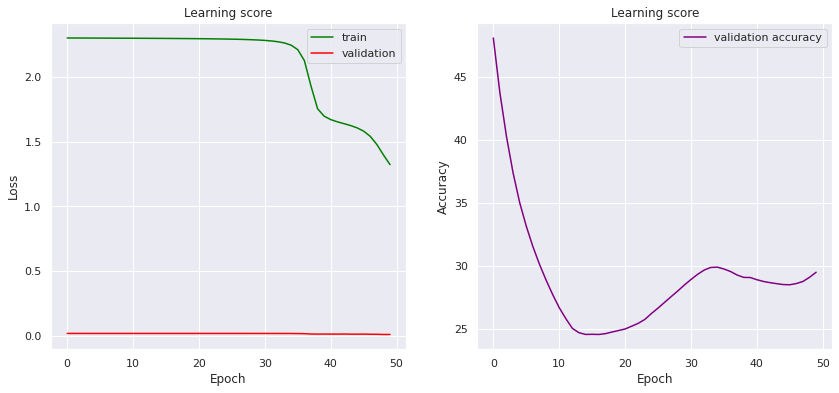

In [41]:
import seaborn as sns
sns.set()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, c="green", label="train")
plt.plot(valid_losses, c="red", label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning score")

plt.subplot(1, 2, 2)
plt.plot(val_accs, c="purple", label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning score")

In [37]:
overfitted_model.load_state_dict(torch.load('overfitted_model.pt'))

<All keys matched successfully>

In [38]:
##################    
# test the model #
##################

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
overfitted_model.eval() # prep model for evaluation
for data, target in test_loader:
    # Forward
    output = overfitted_model(data.to(device))
    loss = loss_func(output, target.to(device))
    
    test_loss += loss.item()*data.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    
    # Calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test Loss: 1.364035

Test Accuracy of     0: 40% (403/1000)
Test Accuracy of     1: 95% (957/1000)
Test Accuracy of     2: 68% (689/1000)
Test Accuracy of     3:  0% ( 9/1000)
Test Accuracy of     4: 18% (186/1000)
Test Accuracy of     5:  4% (45/1000)
Test Accuracy of     6:  0% ( 5/1000)
Test Accuracy of     7: 50% (507/1000)
Test Accuracy of     8: 82% (827/1000)
Test Accuracy of     9: 95% (950/1000)

Test Accuracy (Overall): 45% (4578/10000)


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [46]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [47]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              Tanh-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                 [-1, 1024]       1,049,600
       BatchNorm1d-7                 [-1, 1024]           2,048
              Tanh-8                 [-1, 1024]               0
           Dropout-9                 [-1, 1024]               0
           Linear-10                 [-1, 1024]       1,049,600
      BatchNorm1d-11                 [-1, 1024]           2,048
             Tanh-12                 [-1, 1024]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                 [-

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [49]:
%%time
fixed_model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(fixed_model.parameters(),lr = 0.001)
loss_func = nn.NLLLoss()

n_epochs = 50
valid_loss_min = np.Inf  

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    ###################
    # train the model #
    ###################
    fixed_model.train()
    for data,label in train_loader:
        opt.zero_grad()
        
        # Forward
        output = fixed_model(data.to(device))
        loss = loss_func(output,label.to(device))
        
        # Backward
        loss.backward()
        opt.step()
        
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    fixed_model.eval()
    for data,label in valid_loader:
        # Forward
        output = fixed_model(data.to(device))
        loss = loss_func(output,label.to(device))
        
        valid_loss = loss.item() * data.size(0)
    
    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(fixed_model.state_dict(), 'fixed_model.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Loss: 1.438932 	Validation Loss: 0.005632
Validation loss decreased (inf --> 0.005632).  Saving model ...
Epoch: 2 	Training Loss: 0.831934 	Validation Loss: 0.005660
Epoch: 3 	Training Loss: 0.692067 	Validation Loss: 0.005968
Epoch: 4 	Training Loss: 0.628057 	Validation Loss: 0.004815
Validation loss decreased (0.005632 --> 0.004815).  Saving model ...
Epoch: 5 	Training Loss: 0.590155 	Validation Loss: 0.005880
Epoch: 6 	Training Loss: 0.559933 	Validation Loss: 0.003315
Validation loss decreased (0.004815 --> 0.003315).  Saving model ...
Epoch: 7 	Training Loss: 0.539285 	Validation Loss: 0.003336
Epoch: 8 	Training Loss: 0.525189 	Validation Loss: 0.002642
Validation loss decreased (0.003315 --> 0.002642).  Saving model ...
Epoch: 9 	Training Loss: 0.511967 	Validation Loss: 0.003472
Epoch: 10 	Training Loss: 0.497003 	Validation Loss: 0.002615
Validation loss decreased (0.002642 --> 0.002615).  Saving model ...
Epoch: 11 	Training Loss: 0.490518 	Validation Lo

Text(0.5, 1.0, 'Learning score')

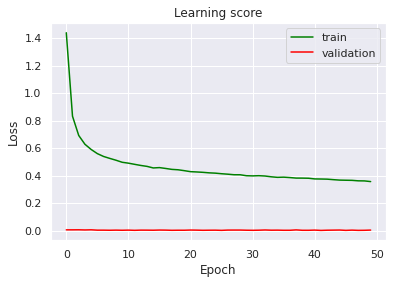

In [50]:
import seaborn as sns
sns.set()

plt.plot(train_losses, c="green", label="train")
plt.plot(valid_losses, c="red", label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning score")

In [51]:
fixed_model.load_state_dict(torch.load('fixed_model.pt'))

<All keys matched successfully>

In [52]:
##################    
# test the model #
##################

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
fixed_model.eval() # prep model for evaluation
for data, target in test_loader:
    # Forward
    output = fixed_model(data.to(device))
    loss = loss_func(output, target.to(device))
    
    test_loss += loss.item()*data.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
    
    # Calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test Loss: 0.414761

Test Accuracy of     0: 82% (822/1000)
Test Accuracy of     1: 95% (957/1000)
Test Accuracy of     2: 76% (764/1000)
Test Accuracy of     3: 88% (880/1000)
Test Accuracy of     4: 78% (788/1000)
Test Accuracy of     5: 92% (921/1000)
Test Accuracy of     6: 65% (650/1000)
Test Accuracy of     7: 94% (945/1000)
Test Accuracy of     8: 96% (969/1000)
Test Accuracy of     9: 95% (951/1000)

Test Accuracy (Overall): 86% (8647/10000)


### Conclusions:
_Write down small report with your conclusions and your ideas._

Скажу честно у меня не получилось нормально переобучить сеть, хотя я перепробовал много разных способов, а именно:
1. уменьшал размер выборки
2. поиграл с количеством скрытых слоев и их размерами
3. пробовал разные функции активации (ReLU, LeakyReLU, Tanh)
4. использовал разные оптимизаторы(Adam, SGD)

Поэтому я был бы очень признателен, если бы Вы сказали, что я делаю не так. 

P.S.: Если можете посоветовать какие-нибудь полезные статьи или литературу на эту тему, то еще раз буду признателен.